In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Flattened Fully Connected Model

In [86]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
   
timeDist = TimeDistributed(Flatten())(inputs)

Dense1 = Dense(50, kernel_initializer='glorot_normal', activation='relu')(timeDist)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_Fully_Connected")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "Flattened_Fully_Connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
dense_38 (Dense)             (None, 52, 50)            500050    
_________________________________________________________________
flatten_31 (Flatten)         (None, 2600)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 10000)             26010000  
Total params: 26,510,050
Trainable params: 26,510,050
Non-trainable params: 0
_________________________________________________________________


## Flattened LSTM Model

In [65]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(100)(timeDist)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               4040400   
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_21 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10000)             1010000   
Total params: 5,060,500
Trainable params: 5,060,500
Non-trainable params: 0
__________________________________________

## 2D CNN LSTM model

In [73]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(50)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "2DCNN_LTSM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_18 (TimeDistri (None, 52, 100, 100, 40          input_9[0][0]                    
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 52, 100, 100, 420         time_distributed_18[0][0]        
__________________________________________________________________________________________________
time_distributed_20 (TimeDistri (None, 52, 50, 50, 2 0           time_distributed_19[0][0]        
_________________________________________________________________________________________

## 2D CNN with LSTM + Attention

In [38]:
from tensorflow.keras import backend as K

In [39]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(10, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(10, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

'''
#Paralell 2D CNN layer
cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])
'''

#send both convolved layer and flattened layer into LSTM
#merge = concatenate([timeDist, timeDist3])

units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line
#For each timestep update a single weight on Dense layer
#Adding a time distributed dense layer instead of previously commented out line of summing 
#over time axis dramatically increased mae by .0002-3 consistently with different models.
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention shape (None, 52, 100)
LSTM_layer1 shape (None, 52, 100)
sent_representation shape (None, 52, 100)
Model: "2DCNN_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 52, 100, 100, 20          input_3[0][0]                    
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 52, 100, 100, 110         time_distributed_10[0][0]        
__________________________________________________________________________________________________
time_distributed_12 (TimeDistri (None, 52, 50, 50, 1 0           time_

## Flattened LSTM + Attention

In [41]:
from tensorflow.keras import backend as K

In [44]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#send both convolved layer and flattened layer into LSTM
timeDist3 = TimeDistributed(Flatten())(inputs)
#merge = concatenate([timeDist, timeDist3])

units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist3)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line

#For each timestep update a single weight on Dense layer
#Adding a time distributed dense layer instead of previously commented out line of summing 
#over time axis dramatically increased mae by .0002-3 consistently with different models.
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation) 

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention shape (None, 52, 100)
LSTM_layer1 shape (None, 52, 100)
sent_representation shape (None, 52, 100)
Model: "2DCNN_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 52, 10000)    0           input_5[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 52, 100)      4040400     time_distributed_15[0][0]        
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 52, 100)      10100       lstm_

## Attention on flattened inputs

In [104]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(25))(timeDist)
units = timeDist2.shape[2]
# compute importance for each step
attention = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
#attention = Dense(1, activation='tanh')(timeDist2)
print('attention.shape: ', attention.shape)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(sent_representation)

timeDist3 = TimeDistributed(Flatten())(inputs)
timeDist4 = TimeDistributed(Dense(25))(timeDist3)
units = timeDist4.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(1, activation='relu'))(sent_representation2)
'''
timeDist5 = TimeDistributed(Flatten())(inputs)
timeDist6 = TimeDistributed(Dense(20))(timeDist5)
units = timeDist6.shape[2]
# compute importance for each step
attention3 = Dense(1, activation='tanh')(timeDist6)
attention3 = Flatten()(attention3)
attention3 = Activation('softmax')(attention3)
attention3 = RepeatVector(units)(attention3)
attention3 = Permute([2, 1])(attention3)
sent_representation3 = Multiply()([timeDist6, attention3])
#For each timestep update a single weight on Dense layer
attended_Dense_out3 = TimeDistributed(Dense(1, activation='relu'))(sent_representation3)
'''
merge = concatenate([attended_Dense_out, attended_Dense_out2])

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(merge))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention.shape:  (None, 52, 1)
Model: "Attention_Time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_196 (TimeDistr (None, 52, 10000)    0           input_45[0][0]                   
__________________________________________________________________________________________________
time_distributed_199 (TimeDistr (None, 52, 10000)    0           input_45[0][0]                   
__________________________________________________________________________________________________
time_distributed_197 (TimeDistr (None, 52, 25)       250025      time_distributed_196[0][0]       
_____________________________________________________

## Frequency from FFT + Attention

In [44]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Frequency Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2, 1])(timeDist) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist.shape',timeDist.shape)
fftLayer = Lambda(lambda x : tf.math.real(tf.signal.rfft(x)))(timeDist) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1])(fftLayer )#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(100))(fftLayer)
units = timeDist4.shape[2]

# compute importance for each frequency
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(sent_representation2)
#attended_Dense_out2 = Lambda(lambda x : K.sum(x, axis=1))(sent_representation2) ## this line

#print('attended_Dense_out',attended_Dense_out.shape[1])
#max_len = attended_Dense_out.shape[1]
#pad1 = tf.constant([[0, max_len-attended_Dense_out2.shape[1]]])

#attended_Dense_out2 = tf.pad(attended_Dense_out2, pad1, mode='CONSTANT')

#merge = concatenate([attended_Dense_out, attended_Dense_out2], axis=1)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out2))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Freq")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


timeDist.shape (None, 10000, 52)
fftLayer.shape (None, 27, 10000)
Model: "Attention_Freq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, 52, 10000)    0           input_5[0][0]                    
__________________________________________________________________________________________________
permute_12 (Permute)            (None, 10000, 52)    0           time_distributed_9[0][0]         
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 27)    0           permute_12[0][0]                 
___________________

## FFT + 2 head Attention(Time,Freq)

In [99]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Time Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(100))(timeDist)
units = timeDist2.shape[2]
# compute importance for each step
attention = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
#attention = Dense(1, activation='tanh')(timeDist2)
print('attention.shape: ', attention.shape)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)
#attended_Dense_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line

#Frequency Head
timeDist3 = TimeDistributed(Flatten())(inputs)
timeDist3 = Permute([2, 1])(timeDist3) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist3.shape',timeDist3.shape)
fftLayer = Lambda(lambda x : tf.math.real(tf.signal.rfft(x)))(timeDist3) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1])(fftLayer )#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(500))(fftLayer)
units = timeDist4.shape[2]

# compute importance for each frequency
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(sent_representation2)
#attended_Dense_out2 = Lambda(lambda x : K.sum(x, axis=1))(sent_representation2) ## this line

#print('attended_Dense_out',attended_Dense_out.shape[1])
#max_len = attended_Dense_out.shape[1]
#pad1 = tf.constant([[0, max_len-attended_Dense_out2.shape[1]]])

#attended_Dense_out2 = tf.pad(attended_Dense_out2, pad1, mode='CONSTANT')

merge = concatenate([attended_Dense_out, attended_Dense_out2], axis=1)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(merge))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Time_Freq")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention.shape:  (None, 52, 1)
timeDist3.shape (None, 10000, 52)
fftLayer.shape (None, 27, 10000)
Model: "Attention_Time_Freq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_190 (TimeDistr (None, 52, 10000)    0           input_43[0][0]                   
__________________________________________________________________________________________________
permute_129 (Permute)           (None, 10000, 52)    0           time_distributed_190[0][0]       
__________________________________________________________________________________________________
lambda_42 (Lambda)              (None, 10000, 27)    0           permute_129[0][

## Run fit on any of the previous model here

In [45]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)



model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=7, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ]
                                   )
valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Train on 88 samples, validate on 28 samples
Epoch 1/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0082 - mae: 0.0082
Epoch 00001: val_loss improved from inf to 0.00794, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 1s 8ms/sample - loss: 0.0081 - mae: 0.0081 - val_loss: 0.0079 - val_mae: 0.0079
Epoch 2/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0078 - mae: 0.0078
Epoch 00002: val_loss improved from 0.00794 to 0.00762, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0078 - mae: 0.0078 - val_loss: 0.0076 - val_mae: 0.0076
Epoch 3/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0075 - mae: 0.

88/88 [==============================] - 0s 2ms/sample - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0044 - val_mae: 0.0044
Epoch 20/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0043 - mae: 0.0043
Epoch 00020: val_loss improved from 0.00439 to 0.00427, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 21/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0041 - mae: 0.0041
Epoch 00021: val_loss improved from 0.00427 to 0.00416, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0041 - mae: 0.0041 - val_loss: 0.0042 - val_mae: 0.0042
Epo

88/88 [==============================] - 0s 2ms/sample - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0029 - val_mae: 0.0029
Epoch 39/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0028 - mae: 0.0028
Epoch 00039: val_loss improved from 0.00290 to 0.00285, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0029 - val_mae: 0.0029
Epoch 40/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0027
Epoch 00040: val_loss improved from 0.00285 to 0.00281, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0027 - mae: 0.0027 - val_loss: 0.0028 - val_mae: 0.0028
Epo

88/88 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 58/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0022 - mae: 0.0022
Epoch 00058: val_loss improved from 0.00231 to 0.00230, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 59/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0022
Epoch 00059: val_loss improved from 0.00230 to 0.00228, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epo

88/88 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 77/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00077: val_loss improved from 0.00208 to 0.00207, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 78/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00078: val_loss improved from 0.00207 to 0.00206, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epo

88/88 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0020 - val_mae: 0.0020
Epoch 96/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0019 - mae: 0.0019
Epoch 00096: val_loss improved from 0.00195 to 0.00195, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 97/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0019 - mae: 0.0019
Epoch 00097: val_loss improved from 0.00195 to 0.00194, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0019
Epo

88/88 [==============================] - 0s 3ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 115/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00115: val_loss improved from 0.00189 to 0.00189, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 116/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00116: val_loss improved from 0.00189 to 0.00188, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
E

88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 134/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00134: val_loss improved from 0.00185 to 0.00185, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 135/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00135: val_loss improved from 0.00185 to 0.00184, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0018 - val_mae: 0.0018
E

88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 153/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00153: val_loss improved from 0.00182 to 0.00182, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 154/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00154: val_loss improved from 0.00182 to 0.00182, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
E

Epoch 172/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00172: val_loss improved from 0.00180 to 0.00180, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 173/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00173: val_loss improved from 0.00180 to 0.00180, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 174/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00174: val_loss improve

88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 191/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00191: val_loss improved from 0.00178 to 0.00178, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 192/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00192: val_loss improved from 0.00178 to 0.00178, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
E

Epoch 210/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00210: val_loss improved from 0.00177 to 0.00177, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 211/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00211: val_loss improved from 0.00177 to 0.00177, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 212/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00212: val_loss improve

Epoch 230/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00230: val_loss improved from 0.00176 to 0.00176, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 231/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00231: val_loss improved from 0.00176 to 0.00176, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 232/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00232: val_loss did not

84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00251: val_loss improved from 0.00175 to 0.00175, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 252/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00252: val_loss improved from 0.00175 to 0.00175, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 253/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00253: val_loss did not improve from 0

88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 275/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00275: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 276/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00276: val_loss improved from 0.00174 to 0.00174, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 277/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00277: val_loss improved from 0.00174 to 0.00174, saving model to /home/zhim

88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 298/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00298: val_loss improved from 0.00174 to 0.00174, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 299/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00299: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 300/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00300: val_loss improved from 0.00174 to 0.00174, saving model to /home/zhim

84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00319: val_loss improved from 0.00173 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 320/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00320: val_loss improved from 0.00173 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 321/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00321: val_loss did not improve from 0

Epoch 343/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00343: val_loss improved from 0.00173 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 344/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00344: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 345/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00345: val_loss improved from 0.00173 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200

88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 366/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00366: val_loss improved from 0.00172 to 0.00172, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 367/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00367: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 368/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00368: val_loss did not improve from 0.00172
88/88 [========================

Epoch 390/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00390: val_loss improved from 0.00172 to 0.00172, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 391/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00391: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 392/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00392: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 393/1000
49/88 [=========

Epoch 414/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00414: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 415/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00415: val_loss improved from 0.00172 to 0.00172, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 416/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00416: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 417/1000
49/88 [=========

Epoch 441/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00441: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 442/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00442: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 443/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00443: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200

88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 467/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00467: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 468/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00468: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 469/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00469: val_loss did not improve from 0.00171
88/88 [========================

Epoch 492/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00492: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 493/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00493: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 494/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00494: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200

Epoch 518/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00518: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 519/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00519: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 520/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00520: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 521/1000
49/88 [=========

Epoch 545/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00545: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 546/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00546: val_loss improved from 0.00170 to 0.00170, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200628-155531_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 547/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00547: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 548/1000
84/88 [=========

Epoch 572/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00572: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 573/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00573: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 574/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00574: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 575/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00575: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss

84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00602: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 603/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00603: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 604/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00604: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 605/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00605: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae:

Epoch 633/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00633: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 634/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0016 - mae: 0.0016Restoring model weights from the end of the best epoch.

Epoch 00634: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 00634: early stopping
28/28 - 0s - loss: 0.0017 - mae: 0.0017
valid_accuracy_MAE=0.0017019241, valid_loss=0.0017019241349771619


#### Adam Optimize:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.001692

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016914

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [43]:
Predict = model.predict(X_valid)

In [44]:
Predict.shape

(28, 10000)

In [45]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [46]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

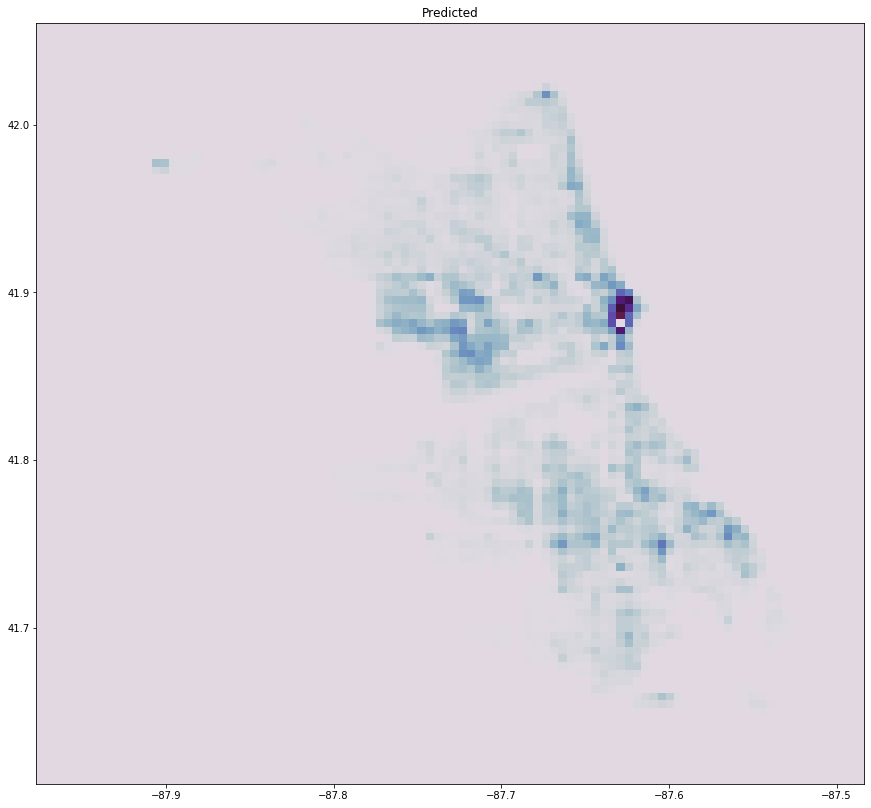

In [79]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
plt.figure(figsize=(18, 14))
plt.title('Predicted')
plt.imshow( X=reshapePred(Predict,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

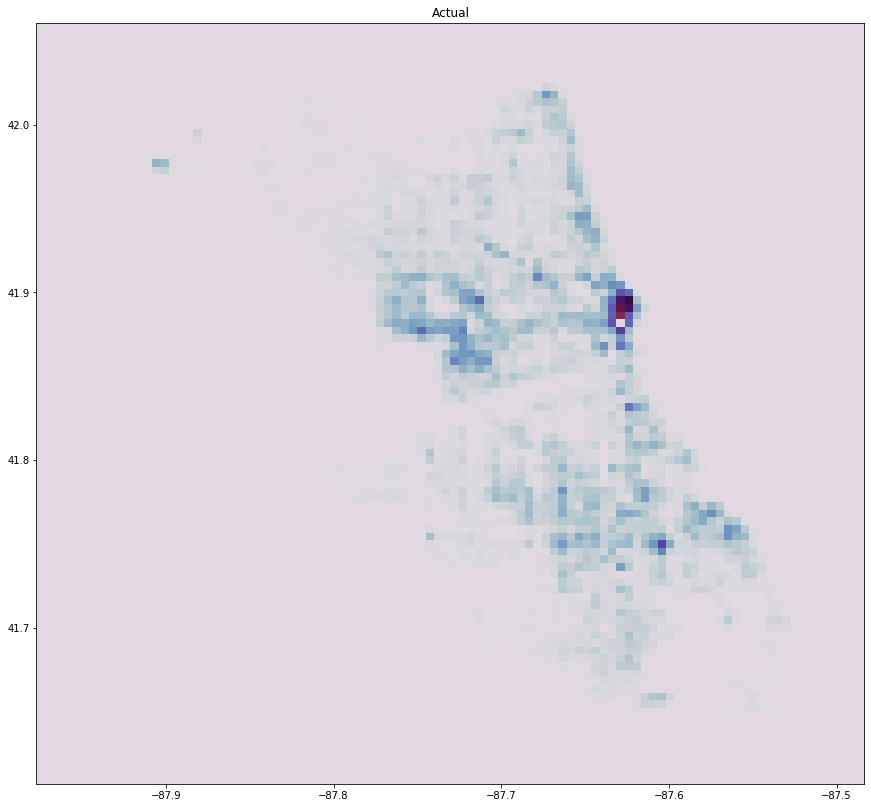

In [80]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=reshapePred(Y_valid,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### We plot the difference between prediction and target

In [81]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [82]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [83]:
np.max(scaled_diff)

1.0

In [84]:
diff

array([[-7.58956958e-07,  7.58956958e-07,  7.58956958e-07, ...,
         7.58956958e-07,  7.58956958e-07, -3.56662395e-06],
       [-7.58956958e-07,  7.58956958e-07, -7.58956958e-07, ...,
        -7.58956958e-07,  7.58956958e-07, -7.58956958e-07],
       [ 3.13577948e-05,  3.56663850e-06,  7.58956958e-07, ...,
         7.58956958e-07,  7.58956958e-07, -7.58956958e-07],
       ...,
       [ 7.58956958e-07,  7.58956958e-07,  3.56663850e-06, ...,
        -3.13577948e-05,  7.58956958e-07, -7.58956958e-07],
       [ 7.58956958e-07, -7.58956958e-07, -1.20610002e-05, ...,
         7.58956958e-07, -7.58956958e-07, -7.58956958e-07],
       [ 1.20610002e-05,  7.58956958e-07,  7.58956958e-07, ...,
         7.58956958e-07, -7.58956958e-07, -7.58956958e-07]])

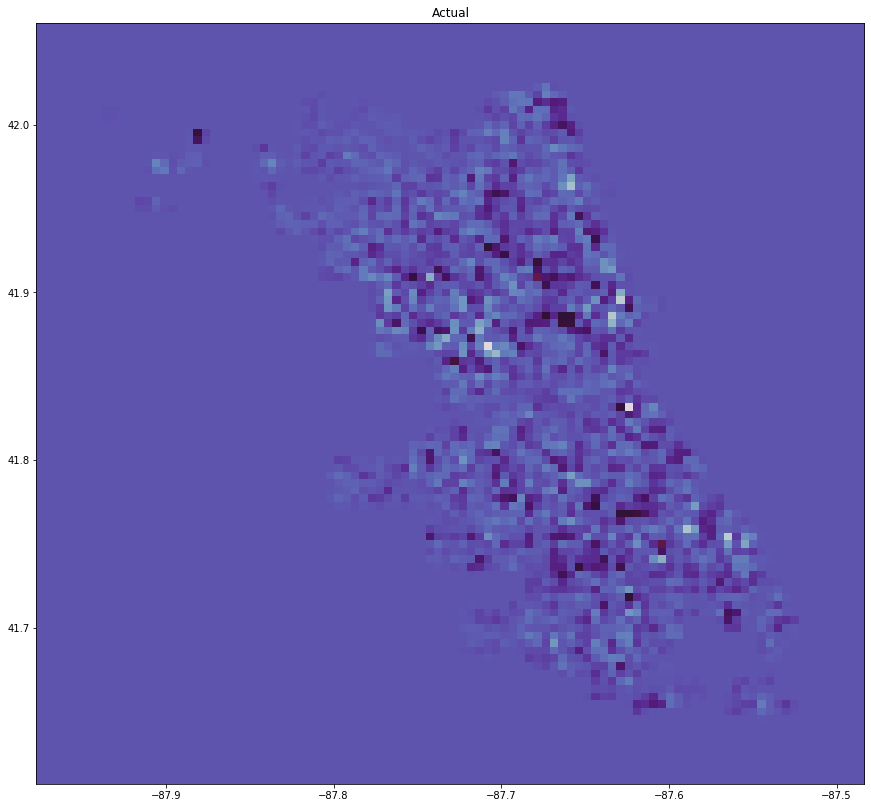

In [85]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.